mode = diffusion, map_type = skip-connection, N = 512, maxvpt = 12.982666666666667
mode = diffusion, map_type = skip-connection, N = 1024, maxvpt = 13.65
mode = diffusion, map_type = skip-connection, N = 2048, maxvpt = 13.65
mode = diffusion, map_type = skip-connection, N = 4096, maxvpt = 13.65
mode = rbf, map_type = skip-connection, N = 512, maxvpt = 11.472066666666668
mode = rbf, map_type = skip-connection, N = 1024, maxvpt = 13.65
mode = rbf, map_type = skip-connection, N = 2048, maxvpt = 13.65
mode = rbf, map_type = skip-connection, N = 4096, maxvpt = 13.65


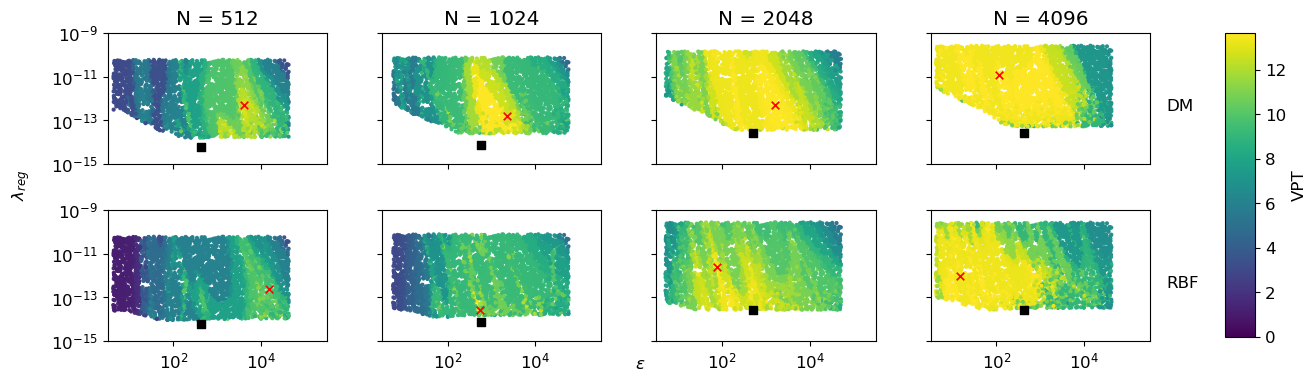

In [3]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))

from diffusion_maps import model_dir


num_points_lst = [512, 1024, 2048, 4096]

cases = [
    ("diffusion", "skip-connection"),
    ("rbf",       "skip-connection"),
]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}

cmap = "viridis"
point_size = 4
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

cv_filename = lambda mode, n, map_type : model_dir + f"/l63/lorenz_3d_cv_result_{mode}_{n}_{map_type}_vl_3000.pkl" 
ref_filename = lambda n : model_dir + f"/l63/lorenz_3d_ref_params_{n}.pkl"

cv_data = {}
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

mdl_idx = 0

for mode, map_type in cases:
    for num_points in num_points_lst:
        fp = cv_filename(mode, num_points, map_type)
        if not os.path.exists(fp):
            print("File does not exist")
            continue
        try:
            with open(fp, "rb") as f:
                df = pickle.load(f)
        except Exception as e:
            print(f"[WARN] failed to read {fp}: {e}")
            continue
        
        eps = df["epsilon"][mdl_idx]
        lam = df["lambda"][mdl_idx]
        vpt = df["vpt"][mdl_idx]
        print(f"mode = {mode}, map_type = {map_type}, N = {num_points}, maxvpt = {np.max(vpt)}")

        lamm = df["lambda_min"][mdl_idx]
        epsc = df["epsilon_c"][mdl_idx]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )

        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, num_points)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))

if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid VPT values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)


def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(cases), len(num_points_lst)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13
CBAR_W  = 0.028
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)


sc_last = None

for r, (mode, map_type) in enumerate(cases):
    for c, num_points in enumerate(num_points_lst):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"N = {num_points}")

        if c == cols - 1:
            ax.set_ylabel(f"{mode_labels[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, num_points)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        ref_param_file = ref_filename(num_points)
        with open(ref_param_file, "rb") as f:
            ref_params = pickle.load(f)
            ref_epsilon = ref_params["epsilon"]
            ref_lambda = ref_params["lambda_reg"]

        eps_c = 10**ref_epsilon[mdl_idx]
        lam_m = 10**ref_lambda[mdl_idx]
        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue
        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]

        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, lam_m, c="black", marker='s', s=30)
        sc_last = sc

        idx = np.nanargmax(vpt_v)
        best_eps = eps_v[idx]
        best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(0.5), 10**(5.5)])
        ax.set_ylim(10**(-15), 10**(-9))

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

x_locator = LogLocator(base=10, numticks=3)
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(2):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(4):
    ax = axs[1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

fig.savefig("./pics/lorenz_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)

/home/jzs6565/diffusion_maps/trained_mdls/l63/lorenz_3d_test_result_diffusion_skip-connection_512_vl_3000.pkl
mode = diffusion, N = 512| mean vpt = 11.028097225600002, std vpt = 2.4102515039345773
/home/jzs6565/diffusion_maps/trained_mdls/l63/lorenz_3d_test_result_diffusion_skip-connection_1024_vl_3000.pkl
mode = diffusion, N = 1024| mean vpt = 13.181363176800001, std vpt = 1.252609506600418
/home/jzs6565/diffusion_maps/trained_mdls/l63/lorenz_3d_test_result_diffusion_skip-connection_2048_vl_3000.pkl
mode = diffusion, N = 2048| mean vpt = 13.842137582000003, std vpt = 0.5932305260056118
/home/jzs6565/diffusion_maps/trained_mdls/l63/lorenz_3d_test_result_diffusion_skip-connection_4096_vl_3000.pkl
mode = diffusion, N = 4096| mean vpt = 14.0976134936, std vpt = 0.4614617072311787
/home/jzs6565/diffusion_maps/trained_mdls/l63/lorenz_3d_test_result_rbf_skip-connection_512_vl_3000.pkl
mode = rbf, N = 512| mean vpt = 8.8680255664, std vpt = 1.7134096757541135
/home/jzs6565/diffusion_maps/trai

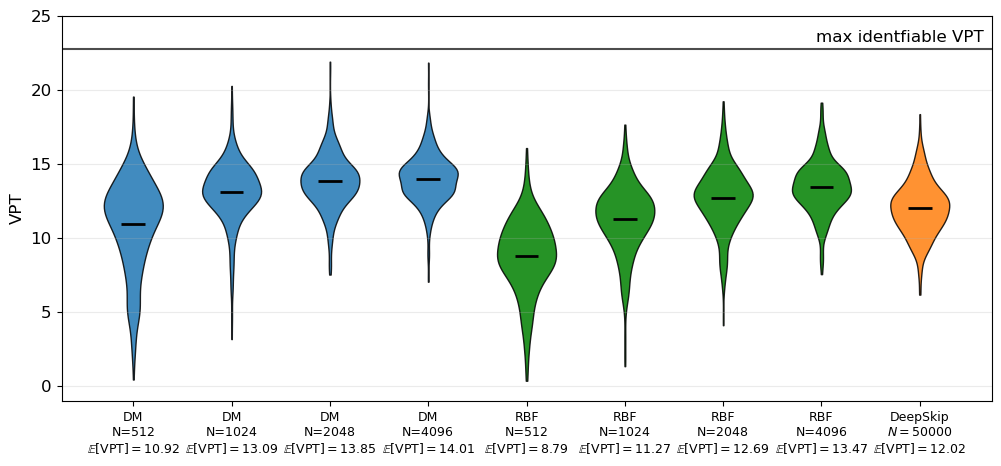

In [ ]:
import os
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))

from diffusion_maps import model_dir, root_dir

filename = lambda mode, n, map_type : str(model_dir) + f"/l63/lorenz_3d_test_result_{mode}_{n}_{map_type}_vl_3000.pkl" 

def load_perf(path):
    print(path)
    if not os.path.exists(path):
        warnings.warn(f"[load_perf] File not found, skipping: {path}")
        return None
    with open(path, "rb") as f:
        perf = pickle.load(f)
    if "vpts_all" not in perf:
        warnings.warn(f"[load_perf] Key 'vpts_all' not found in: {path}. Returning NaN.")
        return None
    vpts = np.asarray(perf["vpts"], dtype=float)
    print(f"mode = {mode}, N = {num_points}| mean vpt = {np.mean(vpts)}, std vpt = {np.std(vpts)}")
    vpts_diag = np.diag(np.asarray(perf["vpts_all"], dtype=float))
    return vpts_diag



def plot_vpt_for_maptype(labels_base, vpt_list, *,
                         digits=2, widths=0.6, color='C0',
                         color_list=None,
                         logy=False, show_means_markers=True):
    
    n = len(labels_base)
    x = np.arange(1, n + 1)

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    vp = ax.violinplot(
        vpt_list,
        positions=x,
        widths=widths,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    if color_list is None:
        color_list = [color] * len(vpt_list)

    for body, c in zip(vp['bodies'], color_list):
        body.set_facecolor(c)
        body.set_edgecolor('black')
        body.set_alpha(0.85)
        body.set_linewidth(1)

    vpt_mean = np.array([np.nanmean(v) for v in vpt_list])
    if show_means_markers:
        for xi, mv in zip(x, vpt_mean):
            ax.hlines(
                mv,
                xi - 0.12,
                xi + 0.12,
                color='black',
                linewidth=2,
                zorder=5,
            )

    if logy:
        ax.set_yscale('log')
    ax.set_ylabel("VPT")

    labels_with_means = []
    for base, mv in zip(labels_base, vpt_mean):
        labels_with_means.append(
            f"{base}\n"
            r"$\mathbb{E}[\mathrm{VPT}]=" + f"{mv:.{digits}f}$"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(labels_with_means, rotation=0, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)

    yline = 25 * 0.91
    ax.axhline(
        y=yline,
        color="k",
        linewidth=1.5,
        alpha=0.7,
        linestyle="-"
    )
    ax.set_ylim([-1, 25])
    ax.text(
        8.8,
        yline + 0.3,
        "max identfiable VPT",
        ha="center",
        va="bottom",
        color="k",
    )
    return fig

def load_deepskip_vpts(path= str(root_dir) + "/external/data/deepskip_best_vpts.csv"):

    deepskip_vpts = np.loadtxt(path, delimiter=",")
    deepskip_vpts = np.ravel(deepskip_vpts)

    print(
        f"DeepSkip best: mean = {np.mean(deepskip_vpts)}, "
        f"std = {np.std(deepskip_vpts)}, "
        f"max = {np.max(deepskip_vpts)}, min = {np.min(deepskip_vpts)}"
    )
    return deepskip_vpts


digits=2
logy=False

mode_lst = ["diffusion", "rbf"]
mode_label = {"diffusion": "DM", "rbf": "RBF"}
mode_to_color = {"diffusion": "C0", "rbf": "g", "deepskip": "tab:orange"}

map_type = 'skip-connection'
num_points_lst = [512, 1024, 2048, 4096]

vpt_lst = []
labels_base = []
color_list = []
for mode in mode_lst:
    for num_points in num_points_lst:
        v = load_perf(filename(mode, map_type, num_points))
        if v is None:
            continue
        vpt_lst.append(v)
        labels_base.append(mode_label[mode] + f'\nN={num_points}')
        color_list.append(mode_to_color[mode])
        



try:
    deepskip_vpts = load_deepskip_vpts()
    labels_base.append("DeepSkip\n" +\
                        "$N = 50000$")
    vpt_lst.append(deepskip_vpts)
    color_list.append(mode_to_color["deepskip"])
except OSError as e:
    print(f"Warning: could not load DeepSkip VPTs: {e}")

fig = plot_vpt_for_maptype(
    labels_base, vpt_lst,
    digits=digits,
    logy=logy,
    show_means_markers=True,
    color_list=color_list,
)

fig.savefig(f"./pics/lorenz_3d_violin_{map_type}.png",
            dpi=600, bbox_inches="tight", transparent=True)


In [10]:
# Lorenz

from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))

from diffusion_maps import model_dir, data_dir

import cupy as cp
from src.krr_model import Modeler
from src.dm_main import DMClass
from src.utils import Manifold
import numpy as np
import pickle


def get_params():

    path = model_dir +  f"/l63/{title}_cv_result_{mode}_{num_points}_{map_type}_vl_3000.pkl"
    with open(path, "rb") as f:
        cv_results = pickle.load(f)
        
    epsilon_array_loc = cv_results["epsilon"]
    lambda_reg_array_loc = cv_results["lambda"]
    data_indices        = cv_results["data_indices"][model_idx]
    score = cv_results["vpt"]

    best_idx       = np.nanargmax(score, axis=1)
    best_epsilon   = epsilon_array_loc[model_idx, best_idx[model_idx]]
    best_lambda_reg = lambda_reg_array_loc[model_idx, best_idx[model_idx]]

    return best_epsilon, best_lambda_reg, data_indices

num_points = 4096
devices = 4
dt = 0.01
mode_list = ["diffusion", "rbf"]
map_type = 'skip-connection'

error_threshold = 0.3 ** 2

title = f"lorenz_3d"
train = np.load(data_dir + "/cached_data/lorenz_train.npy").T
model_idx = 431
test_idx = 301

l63_preds_dict = {
    'diffusion':[],
    'rbf':[]
}

l63_vpts_dict = {
    'diffusion': [],
    'rbf': []
}

test = np.load(data_dir + '/cached_data/lorenz_test.npy').transpose(0, 2, 1)
l63_truePath = test[test_idx]

for mode in mode_list:
    opts = {
    "map_type": map_type,
    "pipeline": "batch",
    }
    
    best_epsilon, best_lambda_reg, data_idx = get_params()
    opts['data'] = train[data_idx:data_idx+num_points]
    model = Modeler(**opts)
    X = cp.asarray(model.inp, dtype=cp.float64)
    n = cp.sum(X * X, axis=1)

    distance_matrix = X @ X.T
    distance_matrix *= -2.0
    distance_matrix += n[:, None]
    distance_matrix += n[None, :]
    cp.maximum(distance_matrix, 0.0, out=distance_matrix)
    cp.sqrt(distance_matrix, out=distance_matrix)
    cp.fill_diagonal(distance_matrix, 0.0)
    distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)
    model.fit_model(best_epsilon, best_lambda_reg, mode, distance_matrix=distance_matrix)
    vpt, tau_f, pred = model.get_performance(
            l63_truePath, dt=dt, Lyapunov_time=1 / 0.91, error_threshold=error_threshold, return_pred=True
        )
    l63_preds_dict[mode].append(cp.asnumpy(pred))
    l63_vpts_dict[mode].append(vpt)

# # solve eigenvalue problem for DM
model.fit_model(best_epsilon, best_lambda_reg, 'diffusion', distance_matrix=distance_matrix)
kernel_matrix = cp.asnumpy(model.dm.kernel_matrix)
q2 = cp.asnumpy(model.dm.q2)

eig, eigv = np.linalg.eig(kernel_matrix[0])
eig = eig.real
eigv = eigv.real

phi = (q2.reshape(-1, 1))**(0.5) * eigv


In [6]:
# ks-chaotic

def get_params():

    path = model_dir + f"/ks_chaotic/ks_chaotic_cv_results_{mode}_{num_points}_{map_type}_vl_4000.pkl"
    with open(path, "rb") as f:
        cv_results = pickle.load(f)
        
    epsilon_array_loc = cv_results["epsilon"]
    lambda_reg_array_loc = cv_results["lambda"]
    data_indices        = cv_results["data_indices"][model_idx]
    score = cv_results["vpt"]

    best_idx       = np.nanargmax(score, axis=1)
    best_epsilon   = epsilon_array_loc[model_idx, best_idx[model_idx]]
    best_lambda_reg = lambda_reg_array_loc[model_idx, best_idx[model_idx]]

    return best_epsilon, best_lambda_reg, data_indices

num_points = 8192
devices = 4
dt = 0.1
mode_list = ["diffusion", "rbf"]
map_type = 'direct'
test_trials = 500
model_idx = 44
test_idx = 274
steps = 2500
error_threshold = 0.5 ** 2

NT = 15_000_000
SKP = 500_000
DT = 0.01
TS = 10
data = pickle.load(open(data_dir + f"/cached_data/ksdata_chaotic_training_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]
xx = data["x"]

NT = 12_500_000
SKP = 500_000
DT = 0.01
TS = 10
test_load = pickle.load(open(data_dir + f"/cached_data/ksdata_chaotic_test_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
uu_test = test_load["udata"].astype(np.float64)
test = uu_test[:steps*test_trials].reshape(test_trials, steps, -1)    
ks_truePath = test[test_idx]

train = data["udata"].astype(np.float64)


ks_preds_dict = {
    'diffusion':[],
    'rbf':[]
}

ks_vpts_dict = {
    'diffusion': [],
    'rbf': []
}

for mode in mode_list:
    opts = {
    "map_type": map_type,
    "pipeline": "batch"
    }
    
    best_epsilon, best_lambda_reg, data_idx = get_params()
    opts['data'] = train[data_idx:data_idx+num_points]
    model = Modeler(**opts)
    X = cp.asarray(model.inp, dtype=cp.float64)
    n = cp.sum(X * X, axis=1)

    distance_matrix = X @ X.T
    distance_matrix *= -2.0
    distance_matrix += n[:, None]
    distance_matrix += n[None, :]
    cp.maximum(distance_matrix, 0.0, out=distance_matrix)
    cp.sqrt(distance_matrix, out=distance_matrix)
    cp.fill_diagonal(distance_matrix, 0.0)
    distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)
    model.fit_model(best_epsilon, best_lambda_reg, mode, distance_matrix=distance_matrix)
    vpt, tau_f, pred = model.get_performance(
            test[test_idx], dt=dt, Lyapunov_time=1 / 0.043, error_threshold=error_threshold, return_pred=True
        )
    ks_preds_dict[mode].append(cp.asnumpy(pred))
    ks_vpts_dict[mode].append(vpt)


Text(0.51, 0.5, 'K-S chaotic system')

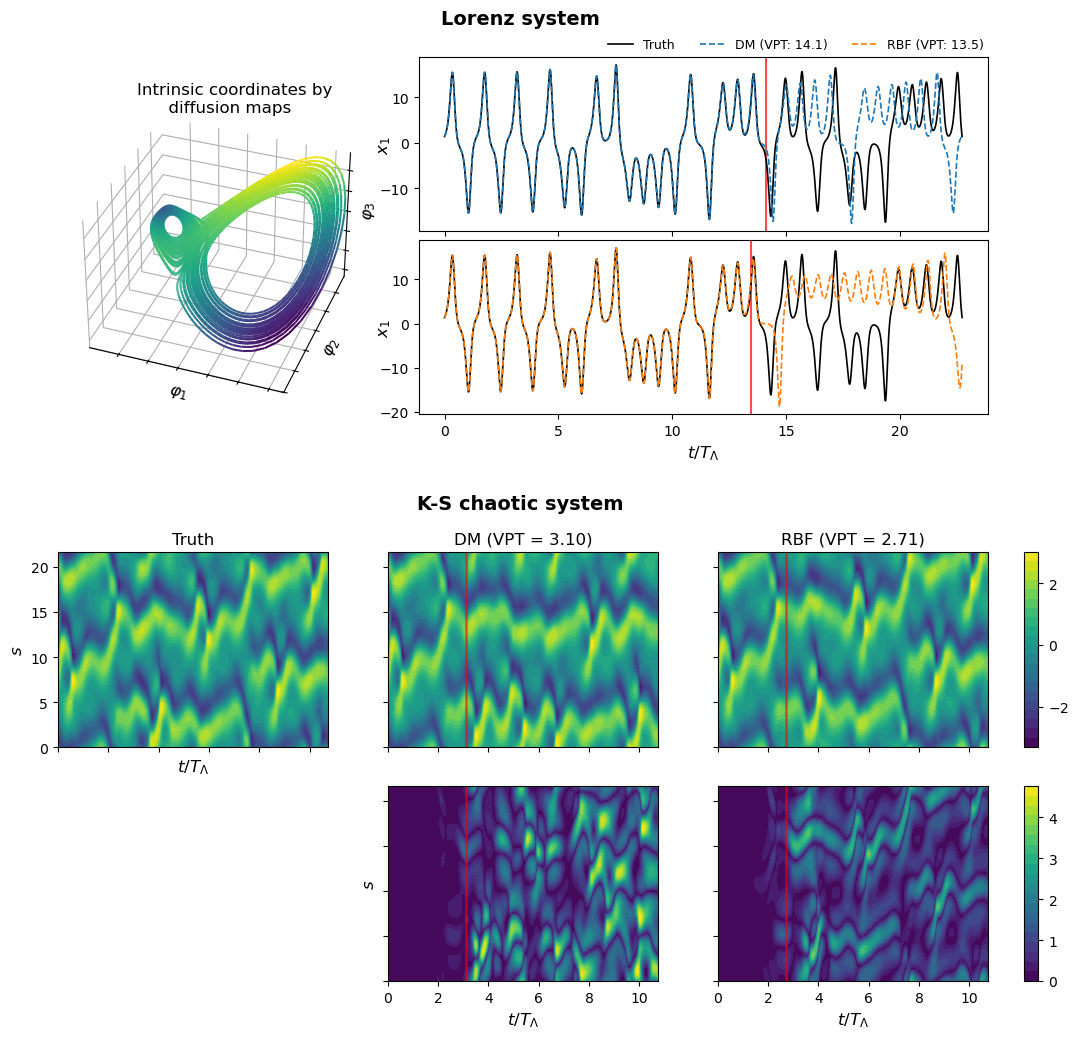

In [11]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

PE_OUTLINE = [pe.withStroke(linewidth=2.0, foreground="white")]

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.012):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom, top = min(bottoms), max(tops)
    height = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

def prettify_cbar(cb, nbins=6, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.update_ticks()

fig = plt.figure(figsize=(12, 12))

'''
    Lorenz system
'''

dt = 0.01
T = 2500
Lyapunov_exp = 0.91
t = np.arange(0, T)*dt
t_scaled = t * Lyapunov_exp

outer_gs = fig.add_gridspec(
    nrows=2,
    ncols=1,
    height_ratios=[1.0, 1.2],
    hspace=0.35,
)

lorenz_outer = outer_gs[0, 0].subgridspec(
    nrows=1,
    ncols=2,
    width_ratios=[1.0, 1.8],
    wspace=0.1,
)

# Left side of Lorenz block: 3D plot shifted downward
lorenz_left = lorenz_outer[0, 0].subgridspec(
    nrows=2,
    ncols=1,
    height_ratios=[0.25, 18.0],
)

ax_3d = fig.add_subplot(lorenz_left[1, 0], projection="3d")

# Right side: DM / RBF time series
lorenz_right = lorenz_outer[0, 1].subgridspec(
    nrows=2,
    ncols=1,
    hspace=0.05,
)

ax_dm_lorenz  = fig.add_subplot(lorenz_right[0, 0])
ax_rbf_lorenz = fig.add_subplot(lorenz_right[1, 0])


X = eig[1:4].reshape(1, -1) * phi[:, 1:4]
X = X.real
points = X.reshape(-1, 1, 3)
X = X.T
segments = np.concatenate([points[:-1], points[1:]], axis=1)

icmap = plt.get_cmap("viridis")
norm = Normalize(vmin=X[2].min(), vmax=X[2].max())
lc_full = Line3DCollection(segments, cmap=icmap, norm=norm)
lc_full.set_array(X[2][:-1])
ax_3d.add_collection3d(lc_full)
ax_3d.set_xlim(X[0].min(), X[0].max())
ax_3d.set_ylim(X[1].min(), X[1].max())
ax_3d.set_zlim(X[2].min(), X[2].max())
ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])
ax_3d.set_facecolor("white")
for axis in (ax_3d.xaxis, ax_3d.yaxis, ax_3d.zaxis):
    axis.pane.set_facecolor("white")
    axis.pane.set_edgecolor("white")
ax_3d.set_xlabel(r'$\varphi_1$', fontsize=12, labelpad=-10)
ax_3d.set_ylabel(r'$\varphi_2$', fontsize=12, labelpad=-10)
ax_3d.set_zlabel(r'$\varphi_3$', fontsize=12, labelpad=-10)
ax_3d.text2D(
    0.25, 0.95,
    "Intrinsic coordinates by \n      diffusion maps",
    transform=ax_3d.transAxes,
    fontsize=12,
    color="black",
)
ax_3d.view_init(elev=35, azim=110)
state_idx = 0

COL_TRUE = "#000000"
COL_DM   = "#1f77b4"
COL_RBF  = "#ff7f0e"
COL_VPT  = "r"

line_truth, = ax_dm_lorenz.plot(
    t_scaled, l63_truePath[:, state_idx],
    color=COL_TRUE, linestyle="-", linewidth=1.2, label="Truth"
)
line_dm, = ax_dm_lorenz.plot(
    t_scaled, l63_preds_dict['diffusion'][0][:, state_idx],
    color=COL_DM, linestyle="--", linewidth=1.2,
    label=f"DM (VPT = {l63_vpts_dict['diffusion'][0]:.1f})"
)
ax_dm_lorenz.axvline(
    x=l63_vpts_dict['diffusion'][0], color=COL_VPT,
    alpha=0.7, linewidth=1.5, zorder=1
)
ax_dm_lorenz.set_xticklabels([])
ax_dm_lorenz.set_ylabel(r"$x_1$", fontsize=12, labelpad=-10)

ax_rbf_lorenz.plot(
    t_scaled, l63_truePath[:, state_idx],
    color=COL_TRUE, linestyle="-", linewidth=1.2, label="Truth"
)
line_rbf, = ax_rbf_lorenz.plot(
    t_scaled, l63_preds_dict['rbf'][0][:, state_idx],
    color=COL_RBF, linestyle="--", linewidth=1.2,
    label=f"RBF (VPT = {l63_vpts_dict['rbf'][0]:.1f})"
)
ax_rbf_lorenz.axvline(
    x=l63_vpts_dict['rbf'][0], color=COL_VPT,
    alpha=0.7, linewidth=1.5, zorder=1
)
ax_rbf_lorenz.set_ylabel(r"$x_1$", fontsize=12, labelpad=-10)
ax_rbf_lorenz.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)

handles = [line_truth, line_dm, line_rbf]
labels  = ["Truth",
           f"DM (VPT: {l63_vpts_dict['diffusion'][0]:.1f})",
           f"RBF (VPT: {l63_vpts_dict['rbf'][0]:.1f})"]

fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.74, 0.905),
    frameon=False,
    fontsize=9,
)

fig.text(
    0.51, 0.92,
    "Lorenz system",
    ha="center", va="top",
    fontsize=14, fontweight="bold",
)

ks_gs  = outer_gs[1, 0].subgridspec(
    nrows=2,
    ncols=3,
    hspace=0.20,
    wspace=0.22,
)


'''
    K-S chaotic system
'''


dt_ks = 0.1
steps_ks = 2500
lye_ks = 0.043
t_ks = np.linspace(0, dt_ks*(steps_ks-1), steps_ks) * lye_ks

ax_truth_ks    = fig.add_subplot(ks_gs[0, 0])
ax_dm_ks       = fig.add_subplot(ks_gs[0, 1], sharex=ax_truth_ks, sharey=ax_truth_ks)
ax_rbf_ks      = fig.add_subplot(ks_gs[0, 2], sharex=ax_truth_ks, sharey=ax_truth_ks)

ax_dm_err_ks   = fig.add_subplot(ks_gs[1, 1], sharex=ax_truth_ks, sharey=ax_truth_ks)
ax_rbf_err_ks  = fig.add_subplot(ks_gs[1, 2], sharex=ax_truth_ks, sharey=ax_truth_ks)


im_truth = ax_truth_ks.contourf(t_ks, xx, ks_truePath.T, levels=21)
truth_levels = im_truth.levels
im_dm_ks  = ax_dm_ks.contourf(t_ks, xx, ks_preds_dict['diffusion'][0].T, levels=truth_levels)
im_rbf_ks = ax_rbf_ks.contourf(t_ks, xx, ks_preds_dict['rbf'][0].T,       levels=truth_levels)

error_dm = np.abs(ks_truePath - ks_preds_dict['diffusion'][0])
error_rbf = np.abs(ks_truePath - ks_preds_dict['rbf'][0])

rmse_dm = np.sqrt(np.mean(error_dm**2))
rmse_rbf = np.sqrt(np.mean(error_rbf**2))


ax_truth_ks.set_title('Truth')
ax_dm_ks.set_title(f"DM (VPT = {ks_vpts_dict['diffusion'][0]:.2f})")
ax_rbf_ks.set_title(f"RBF (VPT = {ks_vpts_dict['rbf'][0]:.2f})")

err_arrays = [
    np.asarray(error_dm),
    np.asarray(error_rbf)
]
vmax_err = max(float(np.nanmax(e)) for e in err_arrays if e.size)
levels_err = np.linspace(0, vmax_err, 21)
im_dm_err_ks  = ax_dm_err_ks.contourf(t_ks, xx, error_dm.T, levels=levels_err)
im_rbf_err_ks = ax_rbf_err_ks.contourf(t_ks, xx, error_rbf.T, levels=levels_err)

axes_shared = [
    ax_truth_ks,
    ax_dm_ks, ax_rbf_ks,
    ax_dm_err_ks, ax_rbf_err_ks,
]
for ax in axes_shared:
    ax.set_xlim(ax_truth_ks.get_xlim())
    ax.set_ylim(ax_truth_ks.get_ylim())
    ax.set_autoscale_on(False)
    ax.label_outer()

ax_truth_ks.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)
ax_truth_ks.set_ylabel(r"$s$", fontsize=12)
ax_dm_err_ks.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)
ax_dm_err_ks.set_ylabel(r"$s$", fontsize=12)
ax_rbf_err_ks.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)

COL_VPT  = "r"

x_dm_vpt   = ks_vpts_dict['diffusion'][0]
x_rbf_vpt  = ks_vpts_dict['rbf'][0]

for ax in (ax_dm_ks, ax_dm_err_ks):
    ax.axvline(x=x_dm_vpt,  color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)

for ax in (ax_rbf_ks, ax_rbf_err_ks):
    ax.axvline(x=x_rbf_vpt,  color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)

row2_axes = [ax_dm_ks, ax_rbf_ks]
row3_axes = [ax_dm_err_ks, ax_rbf_err_ks]

cb1 = add_row_colorbar(fig, row2_axes, im_dm_ks,   left=0.93, width=0.012)
cb2 = add_row_colorbar(fig, row3_axes, im_dm_err_ks, left=0.93, width=0.012)

prettify_cbar(cb1, nbins=5)
prettify_cbar(cb2, nbins=5)


fig.text(
    0.51, 0.5,
    "K-S chaotic system",
    ha="center", va="bottom",
    fontsize=14, fontweight="bold",
)

# fig.savefig("./pics/combined_lorenz_ks.png", bbox_inches="tight", dpi=600, transparent=True)

# Sensitivity Study for validation length

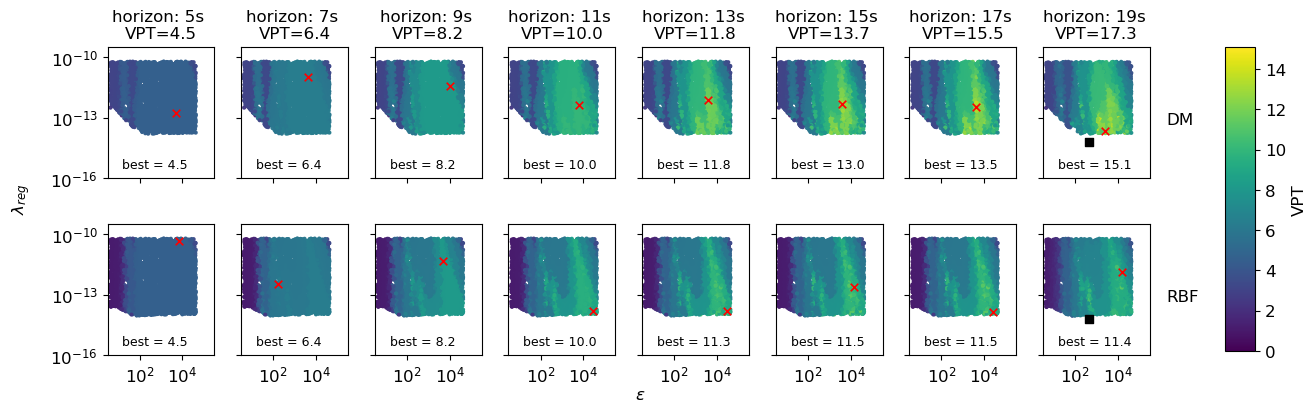

In [ ]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl
np.random.seed(42)

RESULTS_DIR = "numerical_results"
TITLE = "lorenz_3d"

N = 512

ROW_ORDER = [
    ("diffusion", "skip-connection"),
    ("rbf",       "skip-connection"),
]
MODE_LABEL = {"diffusion": "DM", "rbf": "RBF"}

cmap = "viridis"
point_size = 4
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

validation_horizon_lst = [200*i+500 for i in range(8)]


cv_data = {}
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

for mode, map_type in ROW_ORDER:
    for validation_horizon in validation_horizon_lst:
        def cv_path(mode: str, N: int, map_type: str) -> str:
            return os.path.join(RESULTS_DIR, f"lorenz_3d_cv_result_{mode}_{N}_{map_type}_vl_{2*validation_horizon}.pkl")
        fp = cv_path(mode, N, map_type)
        if not os.path.exists(fp):
            print("File does not exist")
            continue
        try:
            with open(fp, "rb") as f:
                df = pickle.load(f)
        except Exception as e:
            print(f"[WARN] failed to read {fp}: {e}")
            continue
        _idx = 0
        eps = df["epsilon"][_idx]
        lam = df["lambda"][_idx]
        vpt = df["vpt"][_idx]

        # print(f"mode = {mode}, map_type = {map_type}, N = {N}, maxvpt = {np.max(vpt)}")

        lamm = df["lambda_min"][_idx]
        epsc = df["epsilon_c"][_idx]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )

        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, validation_horizon)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))

if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid VPT values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)


def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(ROW_ORDER), len(validation_horizon_lst)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13
CBAR_W  = 0.028
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)


sc_last = None

for r, (mode, map_type) in enumerate(ROW_ORDER):
    for c, validation_horizon in enumerate(validation_horizon_lst):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"horizon: {int(validation_horizon*0.01):d}s \nVPT={validation_horizon*0.91*0.01:2.1f}", fontsize=12)

        if c == cols - 1:
            ax.set_ylabel(f"{MODE_LABEL[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, validation_horizon)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        eps_c = D["epsc"]
        lam_m = D["lamm"]

        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        max_vpt = vpt_v.max()                # or np.max(a)
        max_indices = np.argwhere(vpt_v == max_vpt)
        max_v = vpt_v[max_indices]
        max_eps = eps_v[max_indices]
        max_lam = lam_v[max_indices]

        picked_index = np.random.randint(len(max_v))
        best_vpt = max_v[picked_index][0]
        best_eps= max_eps[picked_index]
        best_lam = max_lam[picked_index]


        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, lam_m, c="black", marker='s', s=30)
        sc_last = sc

        # idx = np.nanargmax(vpt_v)
        # best_eps = eps_v[idx]
        # best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(0.5), 10**(5.5)])
        ax.set_ylim(10**(-16), 10**(-9.5))

        ax.text(10**(1.2), 10**(-15.5), f"best = {best_vpt:2.1f}", fontsize=9)

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.00, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(rows):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(cols):
    ax = axs[1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

# fig.savefig("./journal_pics/lorenz_sensitivity_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)


N = 512, mode = diffusion, vl = 500: min VPT = 1.1349338, mean VPT = 7.786347550800001
N = 512, mode = diffusion, vl = 700: min VPT = 1.1349338, mean VPT = 8.506456176399999
N = 512, mode = diffusion, vl = 900: min VPT = 1.1885510000000001, mean VPT = 9.564075102400002
N = 512, mode = diffusion, vl = 1100: min VPT = 1.1885510000000001, mean VPT = 10.4724488232
N = 512, mode = diffusion, vl = 1300: min VPT = 1.1885510000000001, mean VPT = 10.945106244800002
N = 512, mode = diffusion, vl = 1500: min VPT = 1.1885510000000001, mean VPT = 11.028097225600002
N = 512, mode = diffusion, vl = 1700: min VPT = 1.8391282000000004, mean VPT = 11.023927460000003
N = 512, mode = diffusion, vl = 1900: min VPT = 1.8391282000000004, mean VPT = 10.9807760608
N = 512, mode = rbf, vl = 500: min VPT = 0.9641996000000002, mean VPT = 6.550182657200001
N = 512, mode = rbf, vl = 700: min VPT = 0.9641996000000002, mean VPT = 7.508597387200001
N = 512, mode = rbf, vl = 900: min VPT = 1.0469004, mean VPT = 8.44633

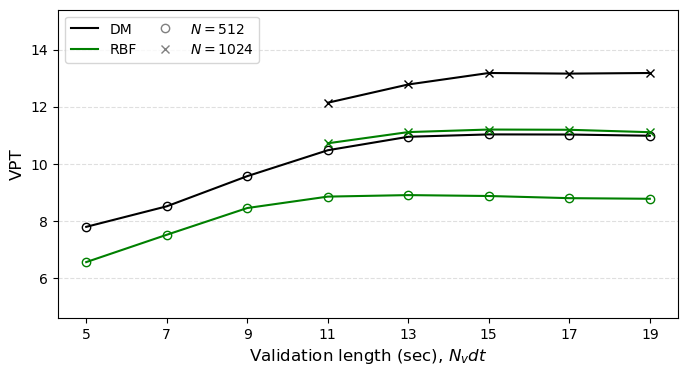

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import os
from matplotlib.lines import Line2D


validation_horizon_dict = {
    '512': [200*i+500 for i in range(8)],
    '1024': [200*i+1100 for i in range(5)]
}
mode_lst = ['diffusion', 'rbf']
map_type = "skip-connection"

num_points_lst = [512, 1024]
mode_labels = ['DM', 'RBF']
fig, ax = plt.subplots(figsize=(8, 4))
horizons = np.arange(1, len(validation_horizon_dict['512']) + 1)
mode_to_color = {"diffusion": "black", "rbf": "green"}
mode_to_shape = {"512": "o-", "1024": "x-"}


ls = []
for i, num_points in enumerate(num_points_lst):
    vpt_dict = {
        'diffusion': [],
        'rbf': [],
    }
    for mode in mode_lst:
        validation_horizon_lst = validation_horizon_dict[str(num_points)]
        for validation_horizon in validation_horizon_lst:

            test_file = f"./numerical_results/lorenz_3d_test_result_{mode}_{map_type}_{num_points}_vl_{2*validation_horizon}.pkl"
            if not os.path.exists(test_file):
                vpt_dict[mode].append([0])
                print(f"File ({test_file}) does not exist")
                continue
            
            with open(test_file, "rb") as f:
                performance = pickle.load(f)

            vpts = performance["vpts"] 
            vpt_dict[mode].append(vpts)
            print(f"N = {num_points}, mode = {mode}, vl = {validation_horizon}: min VPT = {np.min(vpts)}, mean VPT = {np.mean(vpts)}")

        means = np.array([np.array(arr).mean() for arr in vpt_dict[mode]])
        stds  = np.array([np.array(arr).std(ddof=1) for arr in vpt_dict[mode]])

        _l = ax.errorbar(
            validation_horizon_lst,
            means,
            fmt=mode_to_shape[str(num_points)],
            markerfacecolor="none",
            capsize=4,
            color=mode_to_color[mode]
        )
        if num_points == num_points_lst[0]:
            ls.append(_l)

        
from matplotlib import font_manager
serif_prop = font_manager.FontProperties(family='serif')
ax.set_xticks(validation_horizon_dict['512'])
ax.set_xticklabels([f"{int(0.01*v):d}" for v in validation_horizon_dict['512']])
ax.set_xlabel("Validation length (sec), " + r"$N_v dt$", fontsize=12)
ax.set_ylabel("VPT", fontsize=12)
ax.set_ylim([4.6, 15.4])
ax.grid(axis="y", linestyle="--", alpha=0.4)
model_handles = [
    Line2D([0], [0], color='black', linestyle='-', label='DM'),
    Line2D([0], [0], color='green', linestyle='-', label='RBF'),
]

n_handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='none', markerfacecolor='none', label=r'$N=512$'),
    Line2D([0], [0], color='gray', marker='x', linestyle='none', label=r'$N=1024$'),
]

# combine
handles = model_handles + n_handles
labels  = [h.get_label() for h in handles]

leg = ax.legend(
    handles, labels,
    ncol=2,
    loc='upper left',
    columnspacing=1.0,
    handlelength=2.0,
)

fig.savefig(f"./journal_pics/lorenz_sensitivity_test_results.png", dpi=600, bbox_inches="tight", transparent=True)